In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Display options for pandas
pd.options.display.max_columns=100
pd.options.display.max_rows=100
pd.options.display.float_format = '{:.4f}'.format

In [3]:
# Importing the datasets
"""
b - buildings
m - meters
w - weather
"""
df_b = pd.read_csv('building_metadata.csv')
df_m_train = pd.read_csv('train.csv')
df_m_test = pd.read_csv('test.csv')
df_w_train = pd.read_csv('weather_train.csv')
df_w_test = pd.read_csv('weather_test.csv')

# Data preprocessing part

In [4]:
df_b_02 = df_b.sort_values(ascending=True, by = 'square_feet')
df_b_02.reset_index(inplace=True)

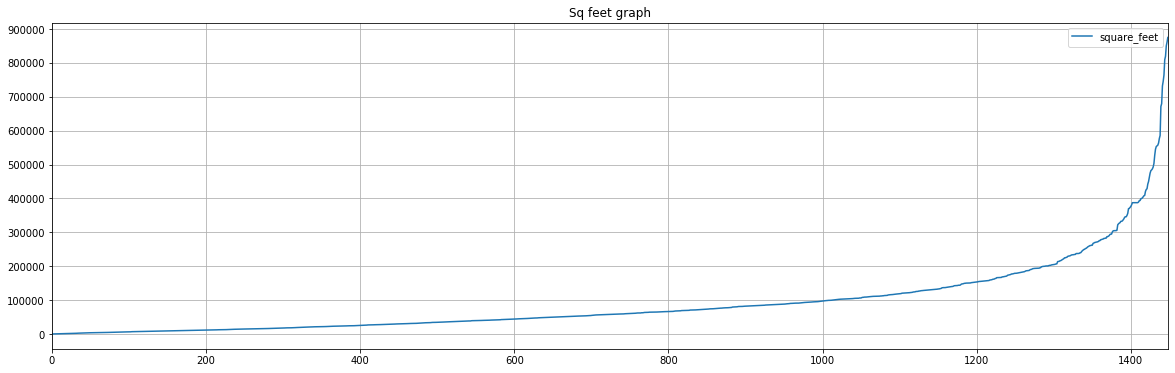

In [5]:
# Distribution of buildings by square feet
plt.figure(figsize=(20,6))
plt.title("Sq feet graph")
df_b_02.square_feet.plot()
plt.yticks(np.arange(0, 1000000, step=100000))
plt.xticks(np.arange(0, 1600, step=200))
plt.grid()
plt.legend()

In [6]:
# Calculation of temperature change within each measurement
df_w_train['temp_change'] = ""
df_w_train['temp_change'][0] = 0
for i in range(1, df_w_train.shape[0]):
    if df_w_train.site_id[i] == df_w_train.site_id[i-1]:
        df_w_train['temp_change'][i] = df_w_train.air_temperature[i] - df_w_train.air_temperature[i-1]
    else:
        df_w_train['temp_change'][i] = 0

df_w_test['temp_change'] = ""
df_w_test['temp_change'][0] = 0
for i in range(1, df_w_test.shape[0]):
    if df_w_test.site_id[i] == df_w_test.site_id[i-1]:
        df_w_test['temp_change'][i] = df_w_test.air_temperature[i] - df_w_test.air_temperature[i-1]
    else:
        df_w_test['temp_change'][i] = 0

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

# Computation of 'floor_count' missing values 

In [7]:
df_b_f = df_b[['building_id', 'square_feet', 'floor_count']]

# Arranging datasets by existence of value
df_b_f_train = df_b_f[df_b_f.floor_count.notnull()]
df_b_f_test = df_b_f[df_b_f.floor_count.isnull()]

# Arranging X-training and X-testing datasets
X_train = df_b_f_train.drop('floor_count', axis=1)
X_test  = df_b_f_test.drop('floor_count', axis=1)

# Arranging y-training datasets
y_train = df_b_f_train['floor_count']

In [8]:
# Regression model
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 300, random_state = 123)
regressor.fit(X_train, y_train)

# Predicting the Test set results
y_pred = regressor.predict(X_test)

In [9]:
# Indroduction of predicted data to the main dataset 'df_b'
y_pred = pd.DataFrame(y_pred)
y_pred = round(y_pred, 0)
y_pred.columns = ['floor_count']

temp_id = pd.DataFrame(X_test.index)
temp_id.columns = ['temp_id']

y_pred = pd.concat([y_pred, temp_id], axis=1)
y_pred.set_index(['temp_id'], inplace=True)

df_pred = pd.concat([X_test, y_pred], axis=1)

In [10]:
# Filling the missing cells
df_pred_ind = list(df_pred.index)
for i in range(0, df_b.shape[0]):
    for j in df_pred_ind:
        if (np.isnan(df_b['floor_count'][i])) and (df_b['building_id'][i] == df_pred['building_id'][j]):
            df_b['floor_count'][i] = df_pred['floor_count'][j]

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Temperature change outliers uncovering

Mean: 0.000225
Std_dev: 1.190653
Upper: 3.572185
Lower: -3.571735
Max: 10.000000
Min: -16.600000
Quantity of outliers: 1583, 0.011326%


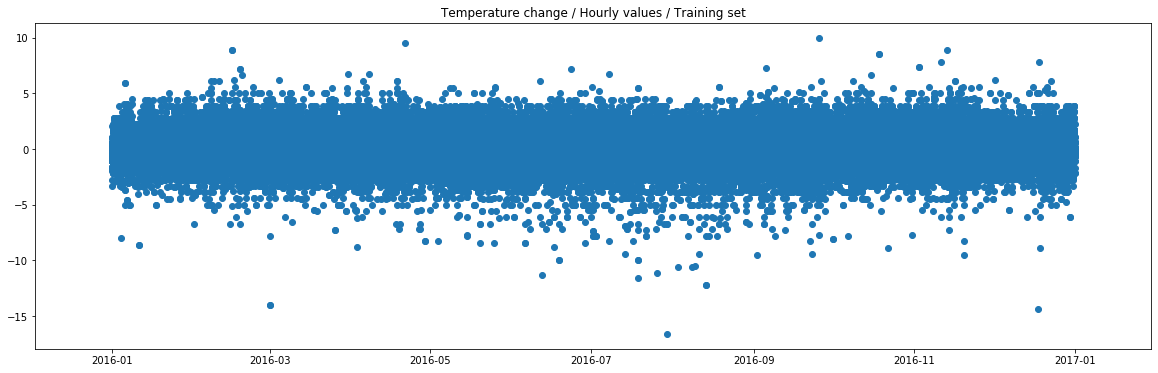

In [11]:
plt.figure(figsize=(20,6))
plt.title("Temperature change / Hourly values / Training set")
plt.scatter(x = pd.to_datetime(df_w_train['timestamp']), y= df_w_train.temp_change)

# Calculate upper and lower boundries for outliers
mean_val = mean(df_w_train.temp_change)
std_val = std(df_w_train.temp_change)
upper = mean_val + std_val * 3
lower = mean_val - std_val * 3

print('Mean: {:f}\nStd_dev: {:f}\nUpper: {:f}\nLower: {:f}\nMax: {:f}\nMin: {:f}'.format(mean_val, 
        std_val, upper, lower, df_w_train.temp_change.max(), df_w_train.temp_change.min()))

# Identify outliers
outliers = [x for x in df_w_train.temp_change if ((x > upper) or (x < lower))]
print('Quantity of outliers: {}, {:f}%'.format(len(outliers), len(outliers)/df_w_train.shape[0]))

Mean: 0.000126
Std_dev: 1.165907
Upper: 3.497847
Lower: -3.497595
Max: 9.300000
Min: -15.600000
Quantity of outliers: 2937, 0.010594%


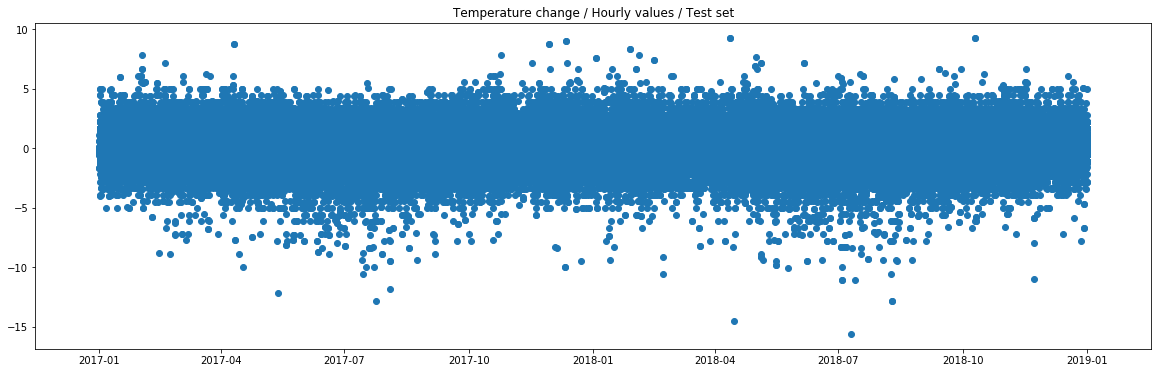

In [12]:
plt.figure(figsize=(20,6))
plt.title("Temperature change / Hourly values / Test set")
plt.scatter(x = pd.to_datetime(df_w_test['timestamp']), y= df_w_test.temp_change)

# Calculate upper and lower boundries for outliers
mean_val = mean(df_w_test.temp_change)
std_val = std(df_w_test.temp_change)
upper = mean_val + std_val * 3
lower = mean_val - std_val * 3

print('Mean: {:f}\nStd_dev: {:f}\nUpper: {:f}\nLower: {:f}\nMax: {:f}\nMin: {:f}'.format(mean_val, 
        std_val, upper, lower, df_w_test.temp_change.max(), df_w_test.temp_change.min()))

# Identify outliers
outliers = [x for x in df_w_test.temp_change if ((x > upper) or (x < lower))]
print('Quantity of outliers: {}, {:f}%'.format(len(outliers), len(outliers)/df_w_test.shape[0]))

# Main dataframes preparation

In [13]:
# Creating one train dataset
df = pd.merge(df_m_train, df_b, how='left', on='building_id')
df = pd.merge(df, df_w_train, how='left', on=['site_id', 'timestamp'])

In [14]:
# Creating one test dataset
df_test = pd.merge(df_m_test, df_b, how='left', on='building_id')
df_test = pd.merge(df_test, df_w_test, how='left', on=['site_id', 'timestamp'])

In [15]:
df.temp_change.fillna(0, inplace=True)
df_test.temp_change.fillna(0, inplace=True)

In [16]:
# Deleting unwanted dataframes
del df_b, df_b_02, df_m_train, df_m_test, df_w_train, df_w_test, df_pred_ind, df_pred, df_b_f, df_b_f_train, df_b_f_test

In [17]:
df[df.columns[:]].corr()['meter_reading'][:].sort_values(ascending=False)

meter_reading         1.0000
year_built            0.1118
square_feet           0.0243
floor_count           0.0217
meter                 0.0177
site_id               0.0119
building_id           0.0088
wind_speed            0.0061
cloud_coverage        0.0060
precip_depth_1_hr     0.0005
temp_change           0.0003
wind_direction       -0.0001
dew_temperature      -0.0033
air_temperature      -0.0041
sea_level_pressure   -0.0042
Name: meter_reading, dtype: float64

In [18]:
# Taking care of categorical values
from sklearn.preprocessing import LabelEncoder
labelencoder_X = LabelEncoder()
df['primary_use'] = labelencoder_X.fit_transform(df['primary_use'].astype(str))
df_test['primary_use'] = labelencoder_X.transform(df_test['primary_use'].astype(str))

In [19]:
df_start_mem = df.memory_usage().sum() / 1024**3
df_test_start_mem = df_test.memory_usage().sum() / 1024**3
print('df memory usage {:5.2f} Gb\ndf_test memory usage {:5.2f} Gb'.format(df_start_mem, df_test_start_mem))

df memory usage  2.64 Gb
df_test memory usage  5.44 Gb


In [20]:
# CONVERTING
# to date format
df['timestamp'] = pd.to_datetime(df['timestamp'])
df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])

# to integer
df.meter = df.meter.astype(int)
df_test.meter = df_test.meter.astype(int)
df.building_id = df.building_id.astype(int)
df_test.building_id = df_test.building_id.astype(int)
df.square_feet = df.square_feet.astype(int)
df_test.square_feet = df_test.square_feet.astype(int)
df.floor_count = df.floor_count.astype(int)
df_test.floor_count = df_test.floor_count.astype(int)

In [21]:
df_finish_mem = df.memory_usage().sum() / 1024**3
df_test_finish_mem = df_test.memory_usage().sum() / 1024**3
print('df memory usage decreased to {:5.2f} Gb ({:.1f}% reduction)'.format(df_finish_mem, 100 * (df_start_mem - df_finish_mem) / df_start_mem))
print('df_test memory usage decreased to {:5.2f} Gb ({:.1f}% reduction)'.format(df_test_finish_mem, 100 * (df_test_start_mem - df_test_finish_mem) / df_test_start_mem))

df memory usage decreased to  2.33 Gb (11.4% reduction)
df_test memory usage decreased to  4.82 Gb (11.4% reduction)


In [22]:
# Creating new features
df['month'] = df['timestamp'].dt.month
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['hour'] = df['timestamp'].dt.hour

df_test['month'] = df_test['timestamp'].dt.month
df_test['day_of_week'] = df_test['timestamp'].dt.dayofweek
df_test['hour'] = df_test['timestamp'].dt.hour

df['en_per_sqf'] = df['meter_reading']/df['square_feet']

In [23]:
df_test.set_index('row_id', inplace=True)

In [24]:
# 0: electricity // 1: chilledwater // 2: steam // 3: hotwater

df0 = df[df.meter == 0]
df1 = df[df.meter == 1]
df2 = df[df.meter == 2]
df3 = df[df.meter == 3]

df0.set_index('timestamp', inplace=True)
df1.set_index('timestamp', inplace=True)
df2.set_index('timestamp', inplace=True)
df3.set_index('timestamp', inplace=True)

# Counters - EDA and outliers uncovering

## 0: electricity

In [25]:
out_list = [[] for i in range(4)]

In [26]:
from scipy.signal import find_peaks
from scipy.signal import argrelmin

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  after removing the cwd from sys.path.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  """


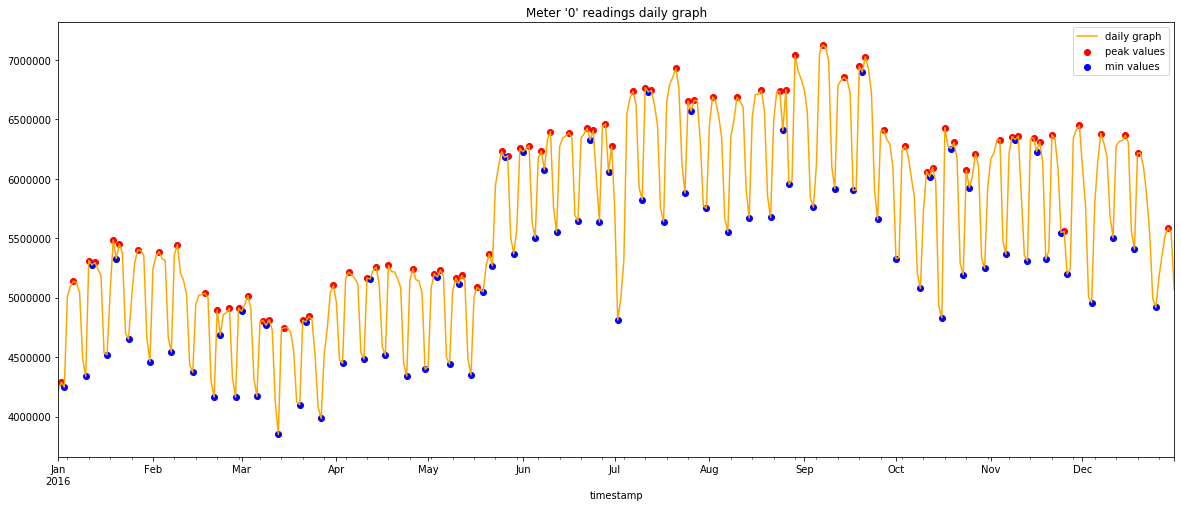

In [27]:
# Resampling the dataframe
df0_year = df0.resample('D').sum()

peaks = find_peaks(df0_year.meter_reading.get_values())[0]
mins = np.array(argrelmin(df0_year.meter_reading.get_values()))

plt.figure(figsize=(20,8))
plt.title("Meter '0' readings daily graph")
df0_year.meter_reading.plot(c = 'orange', label = 'daily graph')
plt.scatter(x = df0_year.index.get_level_values(0)[peaks], y = df0_year.meter_reading[peaks], c = 'red', label = 'peak values')
plt.scatter(x = df0_year.index.get_level_values(0)[mins], y = df0_year.meter_reading[mins], c = 'blue', label = 'min values')
plt.legend()

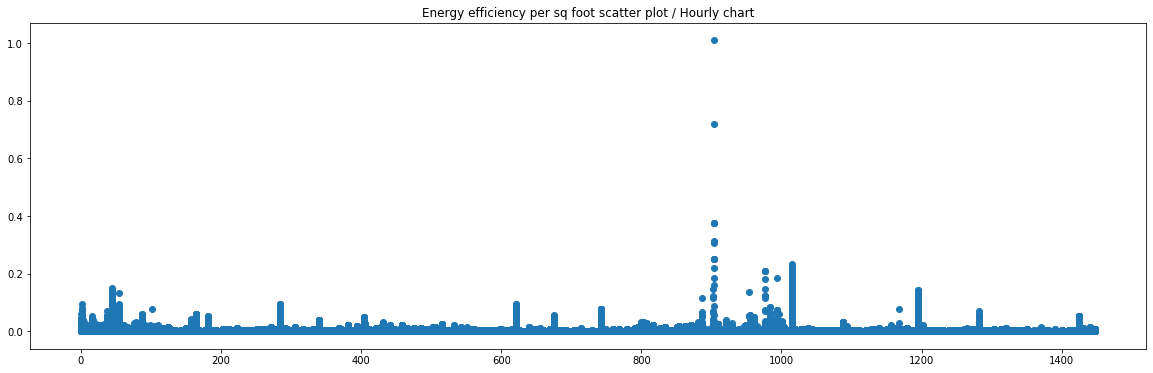

In [28]:
plt.figure(figsize=(20,6))
plt.title("Energy efficiency per sq foot scatter plot / Hourly chart")
plt.scatter(x = df0.building_id, y= df0.en_per_sqf)

In [29]:
# Calculate upper boundry for outliers
mean_val = mean(df0.en_per_sqf)
std_val = std(df0.en_per_sqf)
upper = mean_val + std_val * 3

d_shape_0 = df0.shape[0]
print('Initial df0 shape: {}\n'.format(d_shape_0))
df0 = df0[df0.en_per_sqf < upper]
d_shape_1 = df0.shape[0]

print('Final df0 shape: {}\n'.format(d_shape_1))
print('Meter 0 - Excluded {} rows, {}% of df0 amount'.format(d_shape_0 - d_shape_1, round((d_shape_0 - d_shape_1)/ d_shape_0 *100,1)))

Initial df0 shape: 12060910

Final df0 shape: 11924263

Meter 0 - Excluded 136647 rows, 1.1% of df0 amount


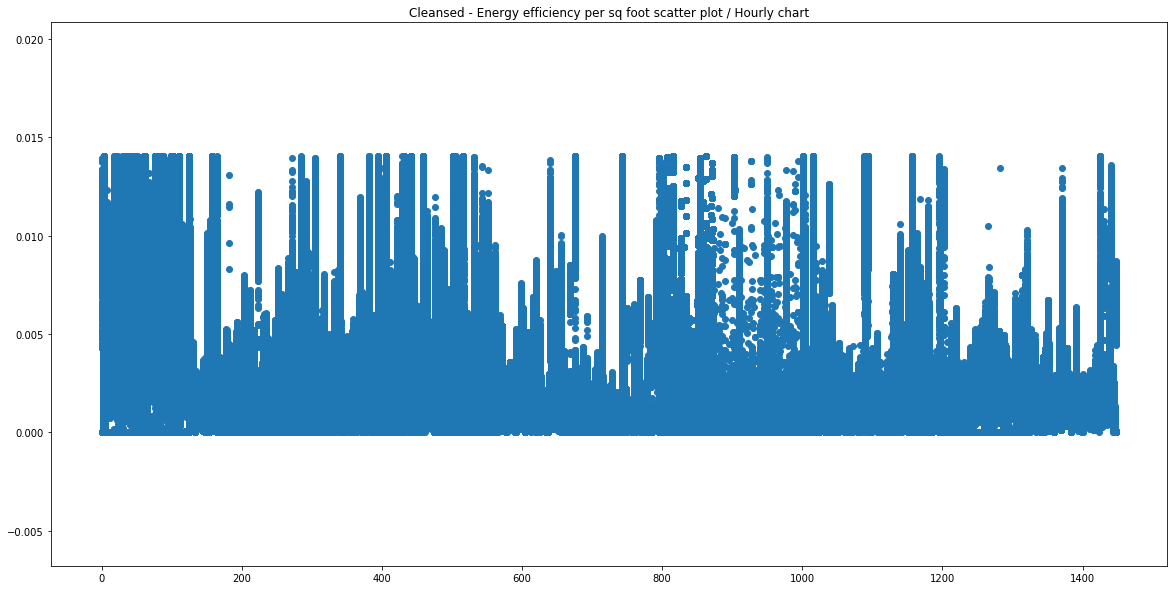

In [30]:
plt.figure(figsize=(20,10))
plt.title("Cleansed - Energy efficiency per sq foot scatter plot / Hourly chart")
plt.scatter(x = df0.building_id, y= df0.en_per_sqf)

## 1: chilledwater

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  after removing the cwd from sys.path.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  """


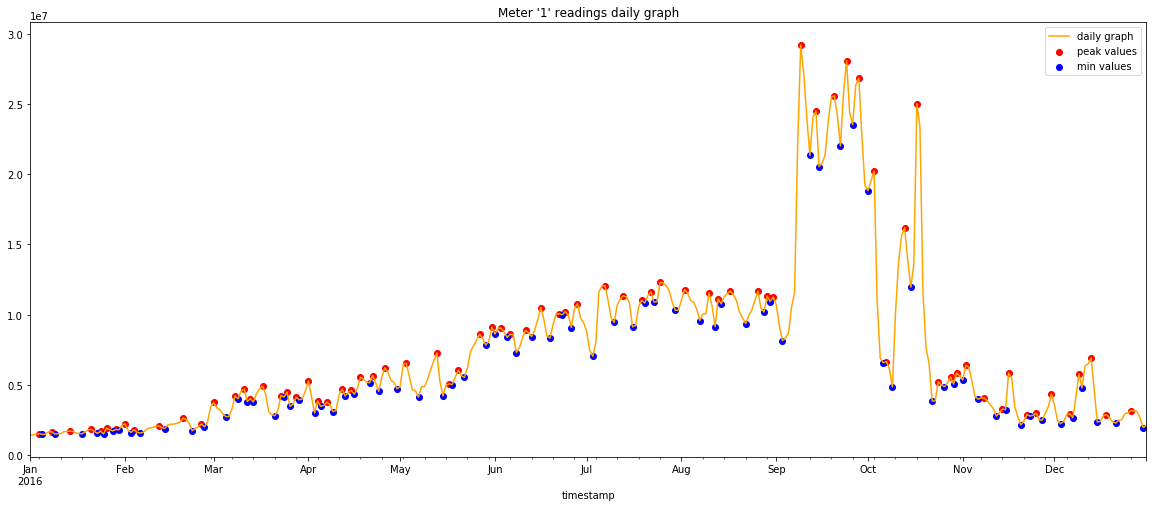

In [31]:
# Resampling the dataframe
df1_year = df1.resample('D').sum()

peaks = find_peaks(df1_year.meter_reading.get_values())[0]
mins = np.array(argrelmin(df1_year.meter_reading.get_values()))

plt.figure(figsize=(20,8))
plt.title("Meter '1' readings daily graph")
df1_year.meter_reading.plot(c = 'orange', label = 'daily graph')
plt.scatter(x = df1_year.index.get_level_values(0)[peaks], y = df1_year.meter_reading[peaks], c = 'red', label = 'peak values')
plt.scatter(x = df1_year.index.get_level_values(0)[mins], y = df1_year.meter_reading[mins], c = 'blue', label = 'min values')
plt.legend()

Quantity of outliers: 5

Outliers values: [4045.5160643461727, 2973.253908365263, 550.301453397396, 509.7348304536582, 499.154531356926]

Outliers buidings ID: [778, 50, 285, 1015, 76]



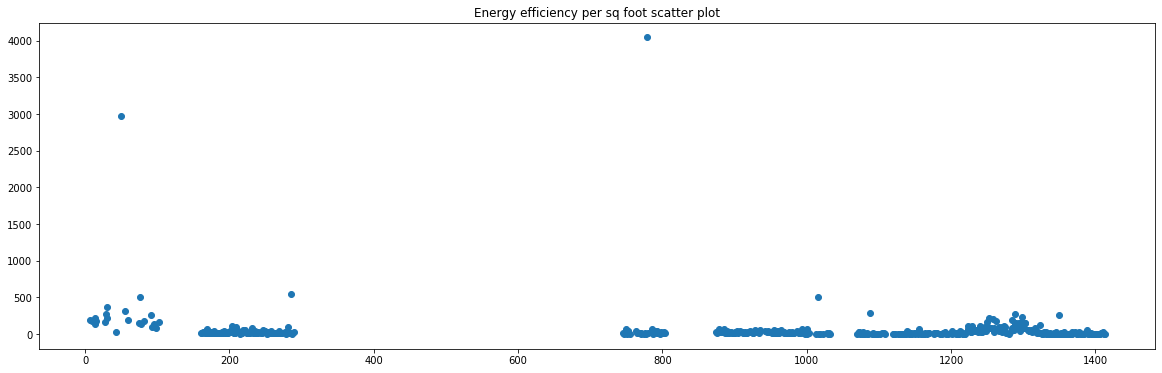

In [32]:
# Resampling the dataframe
df1_year = df1.groupby(['building_id']).resample('Y').sum().sort_values(by='en_per_sqf', ascending=False)

# Calculate upper boundry for outliers
upper = mean(df1_year.en_per_sqf) + std(df1_year.en_per_sqf) * 3

# Identify outliers
outliers = [x for x in df1_year.en_per_sqf if x > 499]  # brutal decision
print('Quantity of outliers: {}\n'.format(len(outliers)))
print('Outliers values: {}\n'.format(outliers))

# Outliers for meter 1 are:
out_list[1] = list(df1_year.index[0:len(outliers)].get_level_values(0))
print('Outliers buidings ID: {}\n'.format(out_list[1]))

plt.figure(figsize=(20,6))
plt.title("Energy efficiency per sq foot scatter plot")
plt.scatter(x = df1_year.index.get_level_values(0), y= df1_year.en_per_sqf)

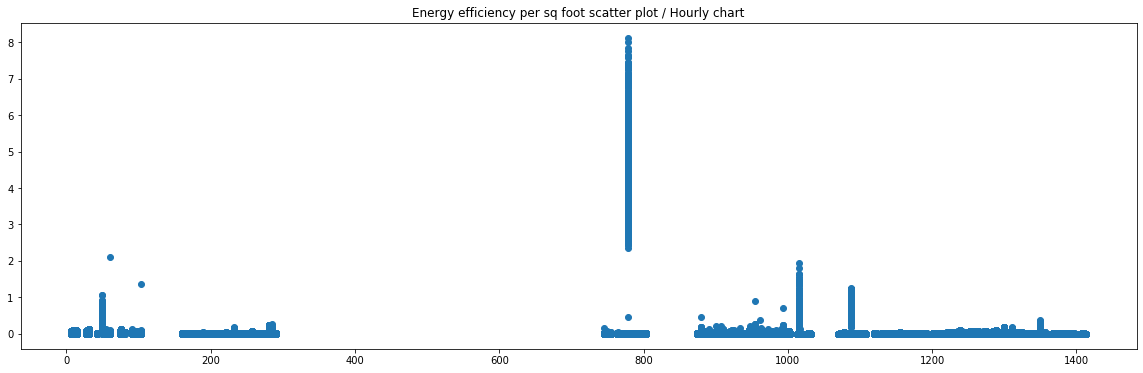

In [33]:
plt.figure(figsize=(20,6))
plt.title("Energy efficiency per sq foot scatter plot / Hourly chart")
plt.scatter(x = df1.building_id, y= df1.en_per_sqf)

In [34]:
# Excluding 5 outliers
d_shape_0 = df1.shape[0]
print('Initial df1 shape: {}\n'.format(d_shape_0))
df1 = df1[df1.building_id.isin(out_list[1]) == False]
d_shape_1 = df1.shape[0]

print('Final df1 shape: {}\n'.format(d_shape_1))
print('Meter 0 - Excluded {} rows, {}% of df1 amount'.format(d_shape_0 - d_shape_1, round((d_shape_0 - d_shape_1)/ d_shape_0 *100,1)))

Initial df1 shape: 4182440

Final df1 shape: 4144397

Meter 0 - Excluded 38043 rows, 0.9% of df1 amount


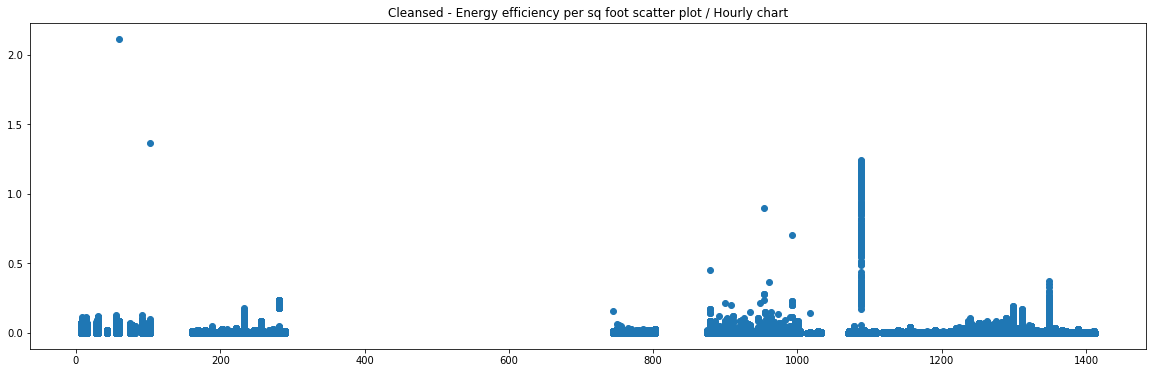

In [35]:
# After excluding building outliers
plt.figure(figsize=(20,6))
plt.title("Cleansed - Energy efficiency per sq foot scatter plot / Hourly chart")
plt.scatter(x = df1.building_id, y= df1.en_per_sqf)

In [36]:
# Calculate upper boundry for outliers
mean_val = mean(df1.en_per_sqf)
std_val = std(df1.en_per_sqf)
upper = mean_val + std_val * 3

d_shape_0 = df1.shape[0]
print('Initial df1 shape: {}\n'.format(d_shape_0))
df1 = df1[df1.en_per_sqf < upper]
d_shape_1 = df1.shape[0]

print('Final df1 shape: {}\n'.format(d_shape_1))
print('Meter 0 - Excluded {} rows, {}% of df1 amount'.format(d_shape_0 - d_shape_1, round((d_shape_0 - d_shape_1)/ d_shape_0 *100,1)))

Initial df1 shape: 4144397

Final df1 shape: 4086252

Meter 0 - Excluded 58145 rows, 1.4% of df1 amount


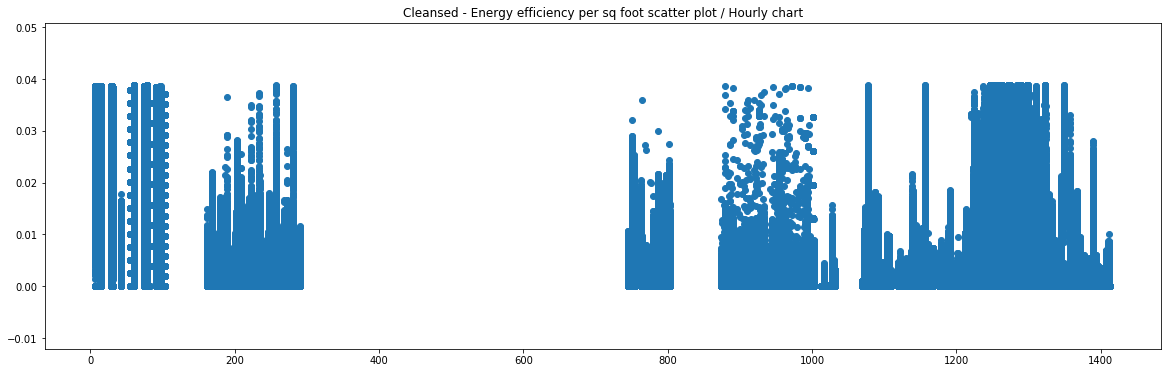

In [37]:
# After excluding building outliers
plt.figure(figsize=(20,6))
plt.title("Cleansed - Energy efficiency per sq foot scatter plot / Hourly chart")
plt.scatter(x = df1.building_id, y= df1.en_per_sqf)

## 2: steam

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  after removing the cwd from sys.path.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  """


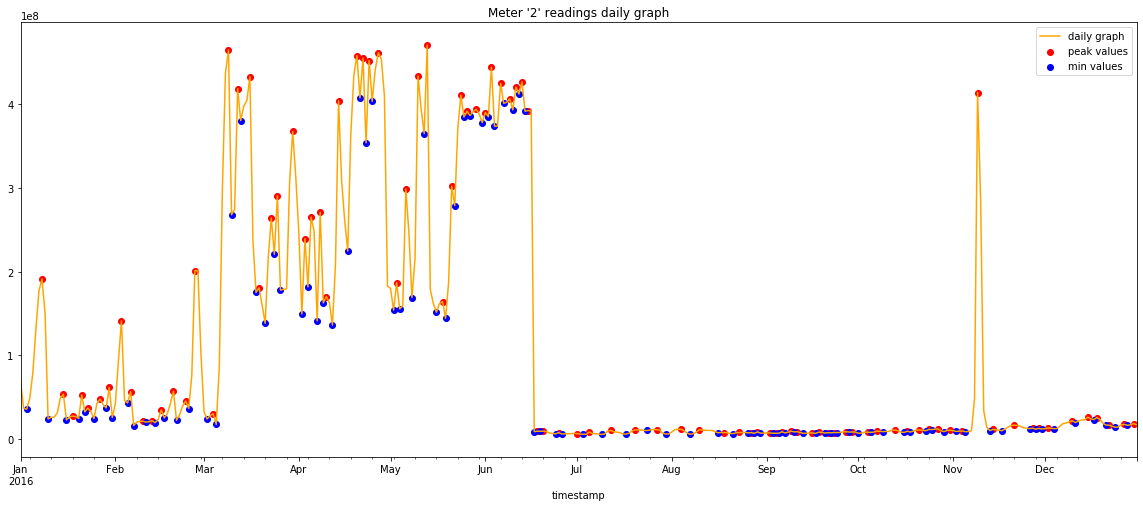

In [38]:
# Resampling the dataframe
df2_year = df2.resample('D').sum()

peaks = find_peaks(df2_year.meter_reading.get_values())[0]
mins = np.array(argrelmin(df2_year.meter_reading.get_values()))

plt.figure(figsize=(20,8))
plt.title("Meter '2' readings daily graph")
df2_year.meter_reading.plot(c = 'orange', label = 'daily graph')
plt.scatter(x = df2_year.index.get_level_values(0)[peaks], y = df2_year.meter_reading[peaks], c = 'red', label = 'peak values')
plt.scatter(x = df2_year.index.get_level_values(0)[mins], y = df2_year.meter_reading[mins], c = 'blue', label = 'min values')
plt.legend()

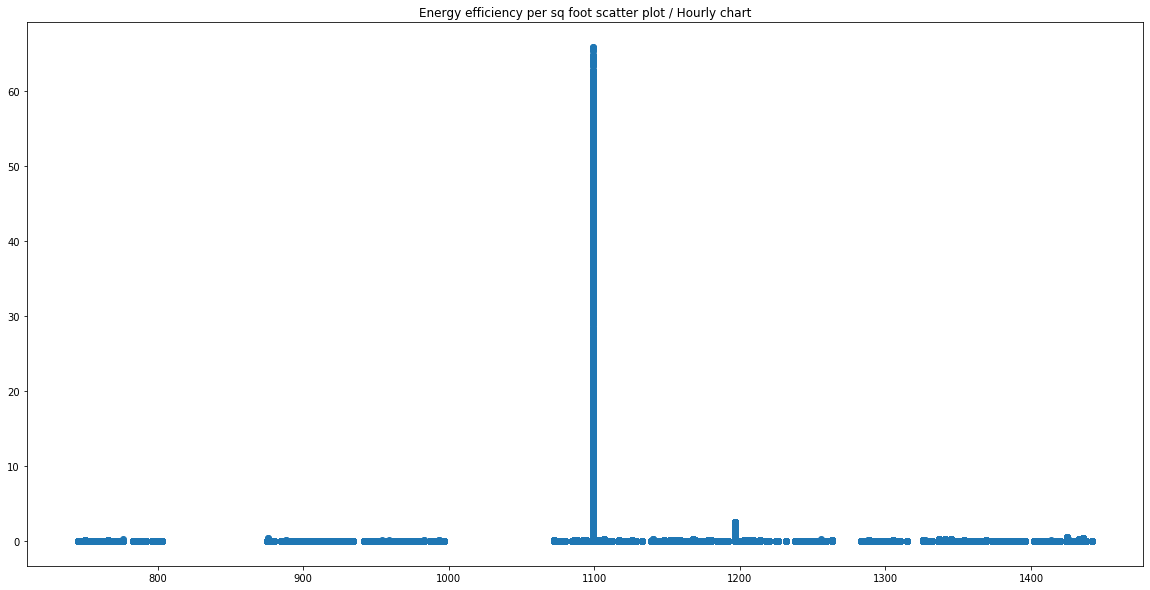

In [39]:
plt.figure(figsize=(20,10))
plt.title("Energy efficiency per sq foot scatter plot / Hourly chart")
plt.scatter(x = df2.building_id, y= df2.en_per_sqf)

In [40]:
# Calculate upper boundry for outliers
mean_val = mean(df2.en_per_sqf)
std_val = std(df2.en_per_sqf)
upper = mean_val + std_val * 3

d_shape_0 = df2.shape[0]
print('Initial df2 shape: {}\n'.format(d_shape_0))
df2 = df2[df2.en_per_sqf < upper]
d_shape_1 = df2.shape[0]

print('Final df2 shape: {}\n'.format(d_shape_1))
print('Meter 0 - Excluded {} rows, {}% of df2 amount'.format(d_shape_0 - d_shape_1, round((d_shape_0 - d_shape_1)/ d_shape_0 *100,1)))

Initial df2 shape: 2708713

Final df2 shape: 2705674

Meter 0 - Excluded 3039 rows, 0.1% of df2 amount


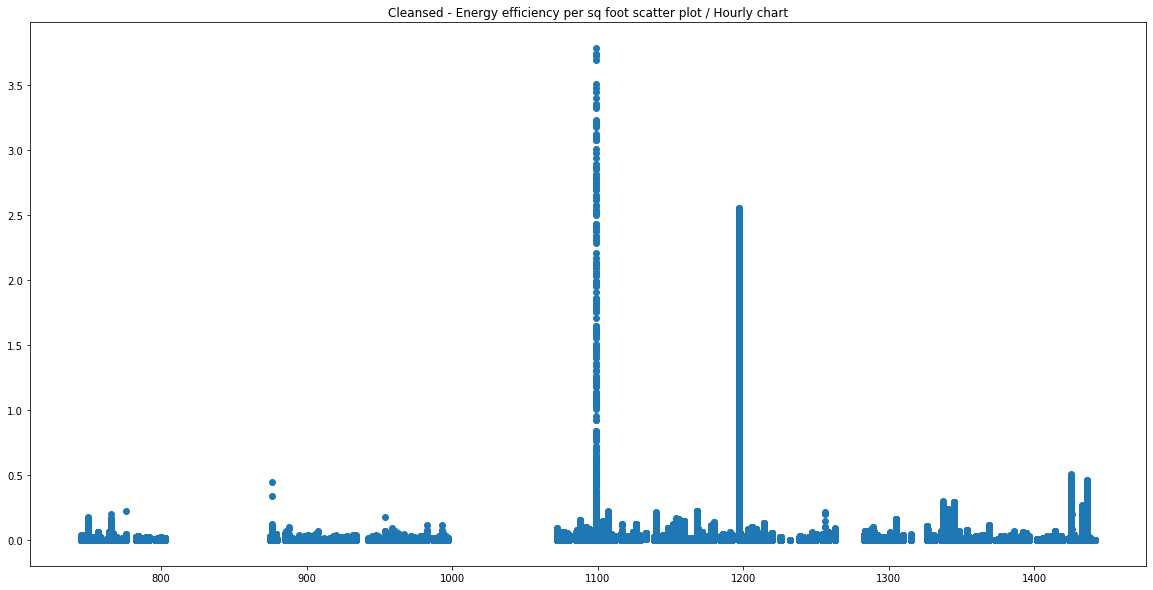

In [41]:
plt.figure(figsize=(20,10))
plt.title("Cleansed - Energy efficiency per sq foot scatter plot / Hourly chart")
plt.scatter(x = df2.building_id, y= df2.en_per_sqf)

## 3: hotwater

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  after removing the cwd from sys.path.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  """


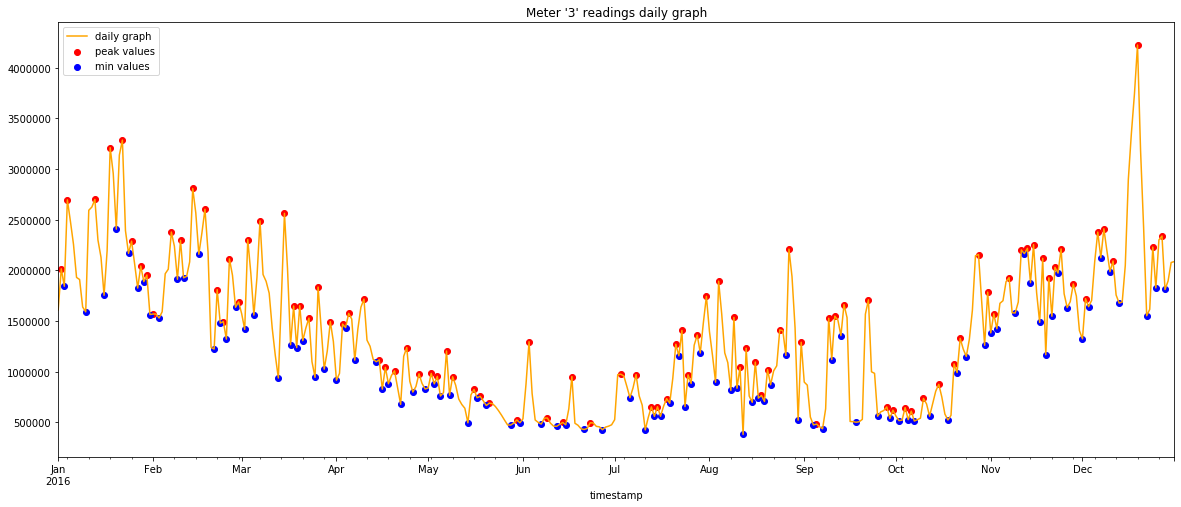

In [42]:
# Resampling the dataframe
df3_year = df3.resample('D').sum()

peaks = find_peaks(df3_year.meter_reading.get_values())[0]
mins = np.array(argrelmin(df3_year.meter_reading.get_values()))

plt.figure(figsize=(20,8))
plt.title("Meter '3' readings daily graph")
df3_year.meter_reading.plot(c = 'orange', label = 'daily graph')
plt.scatter(x = df3_year.index.get_level_values(0)[peaks], y = df3_year.meter_reading[peaks], c = 'red', label = 'peak values')
plt.scatter(x = df3_year.index.get_level_values(0)[mins], y = df3_year.meter_reading[mins], c = 'blue', label = 'min values')
plt.legend()

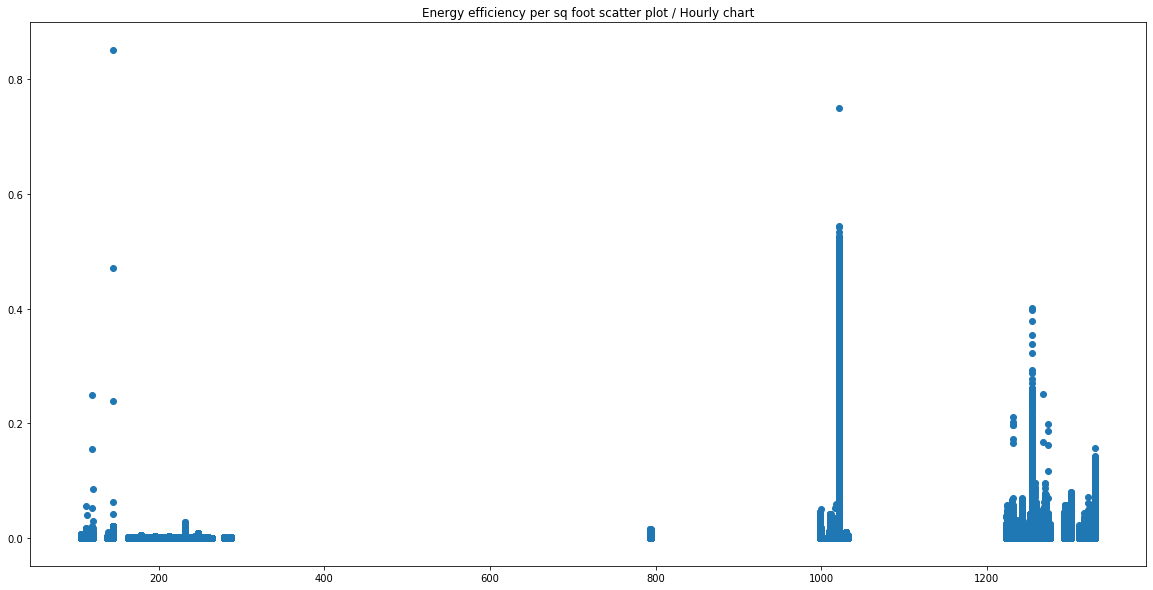

In [43]:
plt.figure(figsize=(20,10))
plt.title("Energy efficiency per sq foot scatter plot / Hourly chart")
plt.scatter(x = df3.building_id, y= df3.en_per_sqf)

In [44]:
# Calculate upper boundry for outliers
mean_val = mean(df3.en_per_sqf)
std_val = std(df3.en_per_sqf)
upper = mean_val + std_val * 3

d_shape_0 = df3.shape[0]
print('Initial df3 shape: {}\n'.format(d_shape_0))
df3 = df3[df3.en_per_sqf < upper]
d_shape_1 = df3.shape[0]

print('Final df3 shape: {}\n'.format(d_shape_1))
print('Meter 0 - Excluded {} rows, {}% of df3 amount'.format(d_shape_0 - d_shape_1, round((d_shape_0 - d_shape_1)/ d_shape_0 *100,1)))

Initial df3 shape: 1264037

Final df3 shape: 1257268

Meter 0 - Excluded 6769 rows, 0.5% of df3 amount


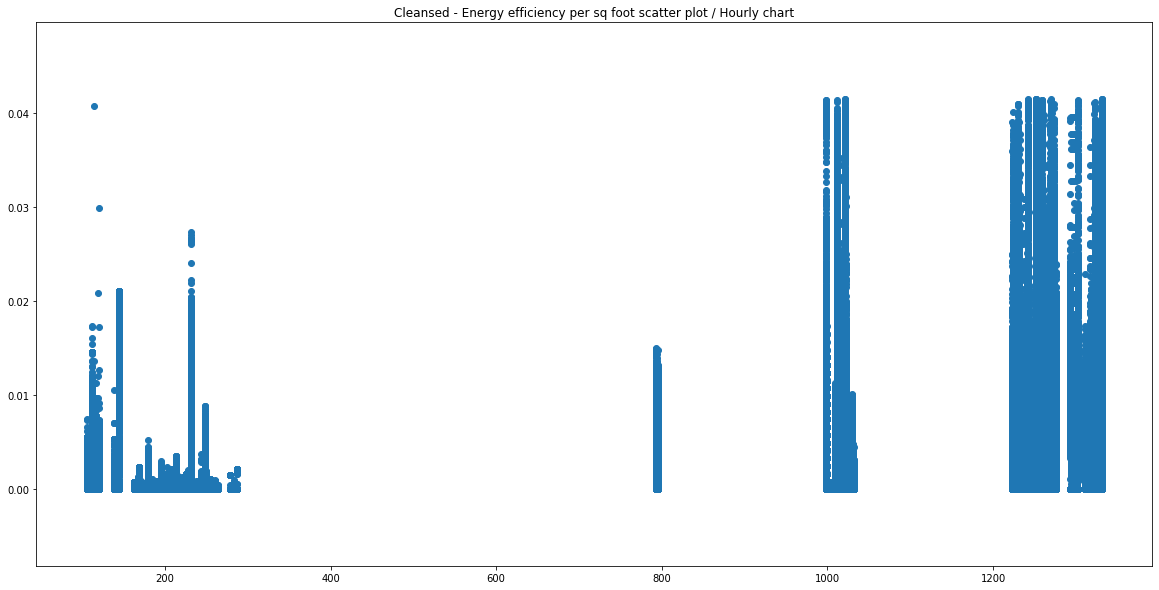

In [45]:
plt.figure(figsize=(20,10))
plt.title("Cleansed - Energy efficiency per sq foot scatter plot / Hourly chart")
plt.scatter(x = df3.building_id, y= df3.en_per_sqf)

In [46]:
df0.append(df1)
df0.append(df2)
df0.append(df3)
df = df0.copy()
df.shape

(11924263, 20)

In [47]:
# Deleting unwanted dataframes
del df0, df1, df2, df3, df0_year, df1_year, df2_year, df3_year

In [48]:
df[df.columns[:]].corr()['meter_reading'][:].sort_values(ascending=False)

meter_reading         1.0000
square_feet           0.6057
en_per_sqf            0.4423
floor_count           0.3814
year_built            0.1012
site_id               0.0351
month                 0.0312
building_id           0.0297
hour                  0.0227
temp_change           0.0219
precip_depth_1_hr     0.0075
wind_direction       -0.0016
dew_temperature      -0.0084
cloud_coverage       -0.0109
sea_level_pressure   -0.0119
air_temperature      -0.0122
wind_speed           -0.0232
day_of_week          -0.0234
primary_use          -0.1272
meter                    nan
Name: meter_reading, dtype: float64

In [49]:
df.reset_index(inplace=True)

# Training and testing sets arrangements

In [50]:
# Dropping unnecessary columns
df.drop(['en_per_sqf', 'timestamp'], axis=1, inplace=True)
df_test.drop(['timestamp'], axis=1, inplace=True)

In [51]:
df.isna().sum()

building_id                 0
meter                       0
meter_reading               0
site_id                     0
primary_use                 0
square_feet                 0
year_built            6417927
floor_count                 0
air_temperature         46931
cloud_coverage        5269822
dew_temperature         48673
precip_depth_1_hr     2497715
sea_level_pressure    1010898
wind_direction         671167
wind_speed              66235
temp_change                 0
month                       0
day_of_week                 0
hour                        0
dtype: int64

In [52]:
df[df.columns[:]].corr()['meter_reading'][:].sort_values(ascending=False)

meter_reading         1.0000
square_feet           0.6057
floor_count           0.3814
year_built            0.1012
site_id               0.0351
month                 0.0312
building_id           0.0297
hour                  0.0227
temp_change           0.0219
precip_depth_1_hr     0.0075
wind_direction       -0.0016
dew_temperature      -0.0084
cloud_coverage       -0.0109
sea_level_pressure   -0.0119
air_temperature      -0.0122
wind_speed           -0.0232
day_of_week          -0.0234
primary_use          -0.1272
meter                    nan
Name: meter_reading, dtype: float64

In [53]:
# Defining DV and IV
X_train = df.drop(['meter_reading'], axis=1)
y_train = df['meter_reading']

In [54]:
X_test = df_test.copy()

# Building a model

In [55]:
# Gradient Boosting Regression
import lightgbm

parameters = {
    'application': 'regression',
    'objective': 'regression',
    'min_child_weight': 0.05,
    'max_depth': -1,
    'metric': 'rmse',
    'boosting': 'gbdt',
    'num_leaves': 50,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 1,
}

# Training and testing data preparation
train_data = lightgbm.Dataset(X_train, label = y_train)

# Model training
regressor = lightgbm.train(parameters,
                       train_data,
                       num_boost_round=2000)

In [56]:
import sys
def sizeof_fmt(num, suffix='b'):
    for unit in ['','K','M','G','T','P','E','Z']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                        X_test:   5.1 Gb
                       df_test:   5.1 Gb
                            df:   1.5 Gb
                       X_train:   1.4 Gb
                       y_train:  91.0 Mb
                        y_pred:  17.1 Kb
                       temp_id:   8.7 Kb
                           ___:   2.2 Kb
                           _48:   2.2 Kb
                             _:   2.1 Kb


In [57]:
del df, df_test, X_train, y_train

In [58]:
y_pred = regressor.predict(X_test)

In [60]:
y_pred = pd.DataFrame(y_pred)

In [61]:
y_pred.columns = ['meter_reading']
y_pred.index.name = 'row_id'

In [62]:
y_pred[y_pred.meter_reading < 0] = 0

In [63]:
y_pred.shape

(41697600, 1)

In [64]:
# Writing to CSV file
y_pred.to_csv(r'submission.csv')